# Analysis of integrating multiple "-omic" datasets from ATAC-STARR

## Introduction

We generated activity, accessibility, and footprinting results from a single ATAC-STARR library. We now want to integrate this information to better investigate gene regulatory regions. 

## Cluster regulatory regions by TF footprint

### Score regions based on presence or absence of a footprint

In [1]:
%%bash
# Output a BED6+ file with a 0 or 1 score in its 7th column representing the absence or presence of a TF motif, respectively. 

#Path Varialbes
ACTIVE='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink/active_regions.bed'
TF_PATH='/data/hodges_lab/ATAC-STARR_B-cells/results/ATAC-STARR_TF-footprinting/BINDetect/GM12878inGM12878_0.05'
OUTPUT_DIR='/data/hodges_lab/ATAC-STARR_B-cells/results/TF-region_clustering'

#Active
#Assign a score of 1 to regions with the footprint and 0 to the regions without a footprint for each TF analyzed. Join all TFs in R. 
#Loop through TFs: 
for TF in IRF4_MA1419.1 ELK1_MA0028.2 NFKB1_MA0105.4 JUNB_MA0490.2 SPI1_MA0080.5 BACH2_MA1101.2 
do
    #-u will report a region if an overlap exists. Add a 1 to these regions in a new column. 
    bedtools intersect -u -a $ACTIVE -b ${TF_PATH}/${TF}/beds/${TF}_GM12878inGM12878_DNA_bound.bed | \
        awk '{OFS=FS="\t"}; BEGIN{print "Chr","Start","End","Peak_ID","Score","Strand",$TF};{print $0,"1"}' - > \
        ${OUTPUT_DIR}/${TF}_tmp-u.bed
        
    #-v will report a region if no overlap exists. Add a 0 to these regions in a new column.  
    bedtools intersect -v -a $ACTIVE -b ${TF_PATH}/${TF}/beds/${TF}_GM12878inGM12878_DNA_bound.bed | \
        awk 'BEGIN{OFS=FS="\t"}{print $0,"0"}' - > ${OUTPUT_DIR}/${TF}_tmp-v.bed
        
    #concatenate theses files and sort. Regions should only exist in either tmp-u or tmp-v not both. Thus the number of lines in the output should equal the number of lines in the input. 
    cat ${OUTPUT_DIR}/${TF}_tmp-u.bed ${OUTPUT_DIR}/${TF}_tmp-v.bed | sort -k1,1 -k2,2n - > \
        ${OUTPUT_DIR}/${TF}-in-GM12878inGM12878_active.bed
        
    rm ${OUTPUT_DIR}/${TF}_tmp-u.bed ${OUTPUT_DIR}/${TF}_tmp-v.bed
done

In [2]:
%%bash
# Output a BED6+ file with a 0 or 1 score in its 7th column representing the absence or presence of a TF motif, respectively. 

#Path Varialbes
SILENT='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink/silent_regions.bed'
TF_PATH='/data/hodges_lab/ATAC-STARR_B-cells/results/ATAC-STARR_TF-footprinting/BINDetect/GM12878inGM12878_0.05'
OUTPUT_DIR='/data/hodges_lab/ATAC-STARR_B-cells/results/TF-region_clustering'

#Active
#Assign a score of 1 to regions with the footprint and 0 to the regions without a footprint for each TF analyzed. Join all TFs in R. 
#Loop through TFs: 
for TF in ZBTB7A_MA0750.2 NFYA_MA0060.3 SP1_MA0079.4 CTCF_MA0139.1
do
    #-u will report a region if an overlap exists. Add a 1 to these regions in a new column. 
    bedtools intersect -u -a $SILENT -b ${TF_PATH}/${TF}/beds/${TF}_GM12878inGM12878_DNA_bound.bed | \
        awk '{OFS=FS="\t"}; BEGIN{print "Chr","Start","End","Peak_ID","Score","Strand",$TF};{print $0,"1"}' - > \
        ${OUTPUT_DIR}/${TF}_tmp-u.bed
        
    #-v will report a region if no overlap exists. Add a 0 to these regions in a new column.  
    bedtools intersect -v -a $SILENT -b ${TF_PATH}/${TF}/beds/${TF}_GM12878inGM12878_DNA_bound.bed | \
        awk 'BEGIN{OFS=FS="\t"}{print $0,"0"}' - > ${OUTPUT_DIR}/${TF}_tmp-v.bed
        
    #concatenate theses files and sort. Regions should only exist in either tmp-u or tmp-v not both. Thus the number of lines in the output should equal the number of lines in the input. 
    cat ${OUTPUT_DIR}/${TF}_tmp-u.bed ${OUTPUT_DIR}/${TF}_tmp-v.bed | sort -k1,1 -k2,2n - > \
        ${OUTPUT_DIR}/${TF}-in-GM12878inGM12878_silent.bed
        
    rm ${OUTPUT_DIR}/${TF}_tmp-u.bed ${OUTPUT_DIR}/${TF}_tmp-v.bed
done

### Cluster regions based on TF score and plot heatmap

In [1]:
library(tidyverse)
library(pheatmap)
library(viridis)
set.seed(123)
library(ggsci)
library(ChIPseeker)
library(clusterProfiler)
library("GenomicRanges")
library(org.Hs.eg.db)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(ReactomePA)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Loading required package: viridisLite



ChIPseeker v1.30.0  For help: https://guangchuangyu.github.io/software/ChIPseeker

If you use ChIPseeker in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Qing-Yu He. ChIPseeker: an R/Bioconductor package for ChIP peak annotation, comparison and visualization. Bioinformatics 2015, 31(14):2382-2383

clusterProfiler v4.2.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W

#### Active

In [2]:
#Read in results and sort by peak_ID for all
dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/TF-region_clustering/'

IRF <- read_tsv(paste0(dir,"IRF4_MA1419.1-in-GM12878inGM12878_active.bed"), skip = 1, 
                col_names = c("chr","start","end","Peak_ID","Score","Strand","IRF")) %>% arrange(Peak_ID)

SPI <- read_tsv(paste0(dir,"SPI1_MA0080.5-in-GM12878inGM12878_active.bed"), skip = 1, 
                col_names = c("chr","start","end","Peak_ID","Score","Strand","SPI")) %>% arrange(Peak_ID)

CREB <- read_tsv(paste0(dir,"JUNB_MA0490.2-in-GM12878inGM12878_active.bed"), skip = 1, 
                 col_names = c("chr","start","end","Peak_ID","Score","Strand","CREB")) %>% arrange(Peak_ID)

NFKB <- read_tsv(paste0(dir,"NFKB1_MA0105.4-in-GM12878inGM12878_active.bed"), skip = 1, 
                 col_names = c("chr","start","end","Peak_ID","Score","Strand","NFKB")) %>% arrange(Peak_ID)

AP1 <- read_tsv(paste0(dir,"BACH2_MA1101.2-in-GM12878inGM12878_active.bed"), skip = 1, 
                col_names = c("chr","start","end","Peak_ID","Score","Strand","AP1")) %>% arrange(Peak_ID) 

ETS <- read_tsv(paste0(dir,"ELK1_MA0028.2-in-GM12878inGM12878_active.bed"), skip = 1, 
                col_names = c("chr","start","end","Peak_ID","Score","Strand","ETS")) %>% arrange(Peak_ID)

Rows: 30078 Columns: 7

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): chr, Peak_ID, Strand
dbl (4): start, end, Score, IRF


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 30078 Columns: 7

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): chr, Peak_ID, Strand
dbl (4): start, end, Score, SPI


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 30078 Columns: 7

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): chr, Peak_ID, Strand
dbl (4): start, end, Score, CREB


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to 

In [3]:
#cbind each TF together. Since Peak_ID order is the same for all, only need to join TF column. 
active <- cbind(IRF, SPI = SPI$SPI, CREB = CREB$CREB, NFKB = NFKB$NFKB, AP1 = AP1$AP1, ETS = ETS$ETS)

#Convert to matrix
active_matrix <- column_to_rownames(active, var = "Peak_ID") %>% dplyr::select(-chr, -start, -end, -Score, -Strand)

#Remove all regions without a footprint. 
active_matrix_subset <- filter(active_matrix, rowSums(active_matrix) != 0)

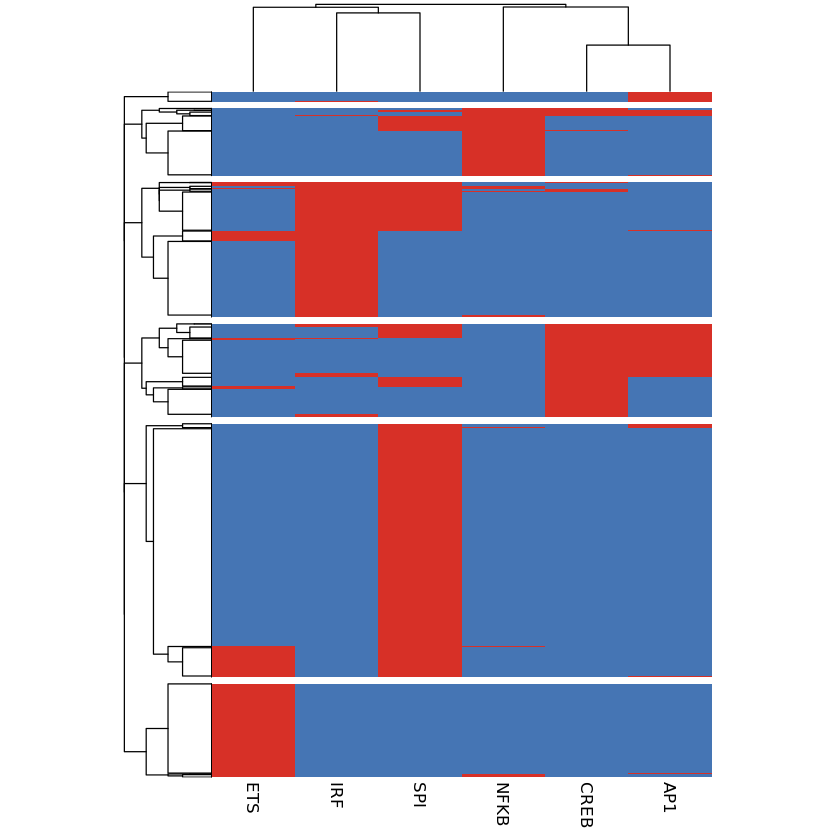

In [4]:
#Heatmap
heatmap <- pheatmap(active_matrix_subset, show_rownames = FALSE, cluster_cols=TRUE, cluster_rows=TRUE, 
                    cellwidth = 50, cutree_rows = 6, display_numbers = FALSE, legend = FALSE, 
                    clustering_distance_rows = 'binary', clustering_distance_cols = 'binary')

In [7]:
pdf("/data/hodges_lab/ATAC-STARR_B-cells/results/NAR_paper_figures/multiomic_heatmap.pdf", width=6, height=8)
heatmap
dev.off()

png 
  2

In [5]:
#Assign cluster number to each region. cbind cluster to the input matrix and then left_join with df to get genomic coordinates.  
active_cluster <- cbind(active_matrix_subset, Cluster = cutree(heatmap$tree_row,k = 6)) %>% 
    rownames_to_column(var = "Peak_ID") %>% 
    left_join(active, by = c("Peak_ID", "IRF", "SPI", "CREB", "NFKB", "AP1", "ETS")) %>% 
    dplyr::select(chr, start, end, Peak_ID, Cluster, IRF, SPI, CREB, NFKB, AP1, ETS)

#split into 6 clusters. 
SPI_clust <- filter(active_cluster, Cluster == 1)
ETS_clust <- filter(active_cluster, Cluster == 2)
AP1_CREB_clust <- filter(active_cluster, Cluster == 3)
IRF_clust <- filter(active_cluster, Cluster == 4)
NFKB_clust <- filter(active_cluster, Cluster == 5)
AP1_clust <- filter(active_cluster, Cluster == 6)

In [6]:
#make gRanges object and annotate peaks to assign nearest neighbor. 
ETS_anno <- annotatePeak(with(ETS_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                         TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

IRF_anno <- annotatePeak(with(IRF_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                         TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

SPI_anno <- annotatePeak(with(SPI_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                         TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

AP1_CREB_anno <- annotatePeak(with(AP1_CREB_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                              TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

NFKB_anno <- annotatePeak(with(NFKB_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                          TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

AP1_anno <- annotatePeak(with(AP1_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                          TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

>> preparing features information...		 2022-02-04 12:53:48 PM 
>> identifying nearest features...		 2022-02-04 12:53:52 PM 
>> calculating distance from peak to TSS...	 2022-02-04 12:53:52 PM 
>> assigning genomic annotation...		 2022-02-04 12:53:52 PM 
>> adding gene annotation...			 2022-02-04 12:54:40 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-02-04 12:54:50 PM 
>> done...					 2022-02-04 12:54:50 PM 
>> preparing features information...		 2022-02-04 12:54:50 PM 
>> identifying nearest features...		 2022-02-04 12:54:50 PM 
>> calculating distance from peak to TSS...	 2022-02-04 12:54:51 PM 
>> assigning genomic annotation...		 2022-02-04 12:54:51 PM 
>> adding gene annotation...			 2022-02-04 12:54:57 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-02-04 12:54:57 PM 
>> done...					 2022-02-04 12:54:57 PM 
>> preparing features information...		 2022-02-04 12:54:57 PM 
>> identifying nearest features...		 2022-02-04 12:54:57 PM 
>> calculating distance from peak to TSS...	 2022-02-04 12:54:58 PM 
>> assigning genomic annotation...		 2022-02-04 12:54:58 PM 
>> adding gene annotation...			 2022-02-04 12:55:03 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-02-04 12:55:03 PM 
>> done...					 2022-02-04 12:55:03 PM 
>> preparing features information...		 2022-02-04 12:55:03 PM 
>> identifying nearest features...		 2022-02-04 12:55:03 PM 
>> calculating distance from peak to TSS...	 2022-02-04 12:55:04 PM 
>> assigning genomic annotation...		 2022-02-04 12:55:04 PM 
>> adding gene annotation...			 2022-02-04 12:55:09 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-02-04 12:55:09 PM 
>> done...					 2022-02-04 12:55:09 PM 
>> preparing features information...		 2022-02-04 12:55:09 PM 
>> identifying nearest features...		 2022-02-04 12:55:09 PM 
>> calculating distance from peak to TSS...	 2022-02-04 12:55:09 PM 
>> assigning genomic annotation...		 2022-02-04 12:55:09 PM 
>> adding gene annotation...			 2022-02-04 12:55:15 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-02-04 12:55:15 PM 
>> done...					 2022-02-04 12:55:15 PM 
>> preparing features information...		 2022-02-04 12:55:15 PM 
>> identifying nearest features...		 2022-02-04 12:55:15 PM 
>> calculating distance from peak to TSS...	 2022-02-04 12:55:15 PM 
>> assigning genomic annotation...		 2022-02-04 12:55:15 PM 
>> adding gene annotation...			 2022-02-04 12:55:21 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-02-04 12:55:21 PM 
>> done...					 2022-02-04 12:55:21 PM 


In [7]:
#perform reactome pathway enrichment analysis of nearest neighbor gene sets. Make list of genes first. Then run on all simultaneously with clusterProfiler
gene_list <- list(ETS = as.data.frame(ETS_anno)$geneId, IRF = as.data.frame(IRF_anno)$geneId, 
                  NFKB = as.data.frame(NFKB_anno)$geneId, `AP1&CREB` = as.data.frame(AP1_CREB_anno)$geneId, 
                  SPI = as.data.frame(SPI_anno)$geneId, AP1 = as.data.frame(AP1_anno)$geneId)

reactome_results <- compareCluster(gene_list, fun = "enrichPathway", pvalueCutoff = 0.05)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



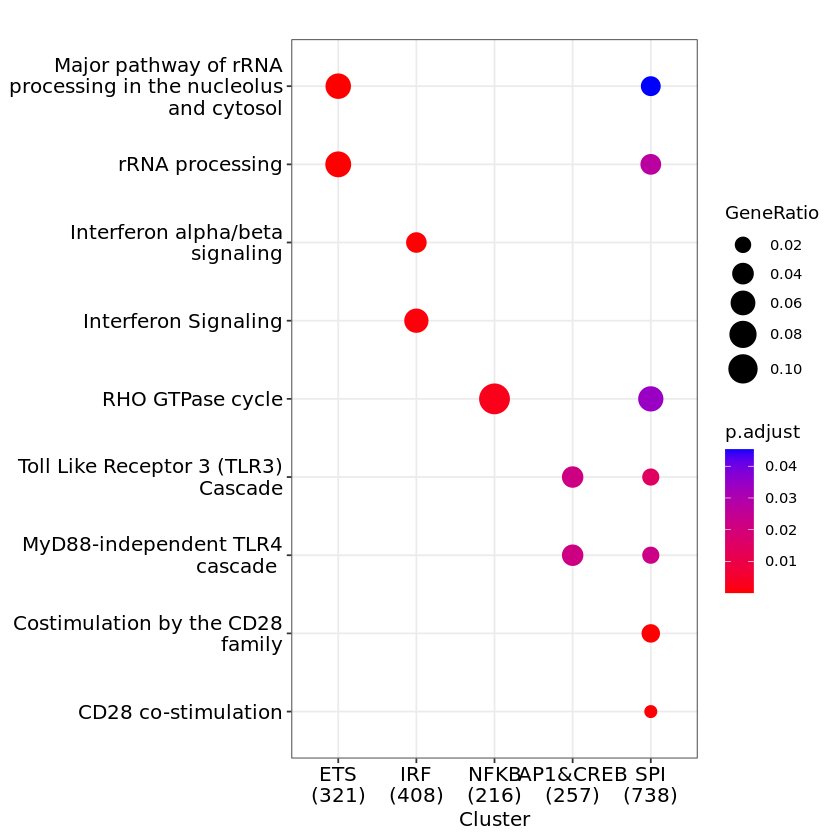

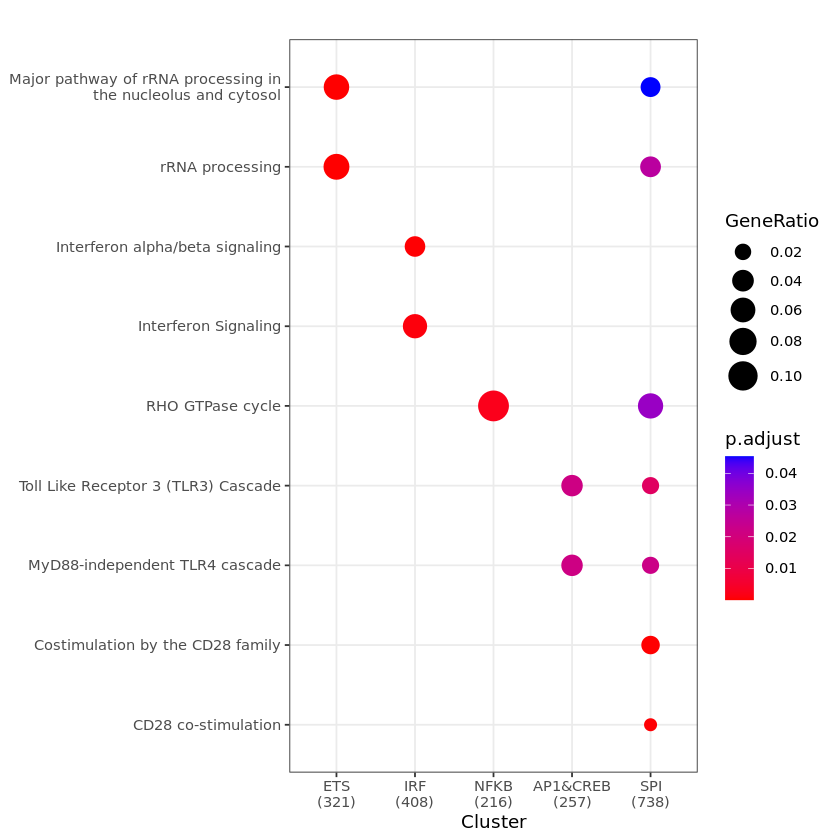

In [8]:
p <- dotplot(reactome_results, showCategory = 2) + theme_bw() + scale_y_discrete(labels = function(x) str_wrap(x, width = 35))
p

In [9]:
ggsave(p, filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/NAR_paper_figures/reactome-active.pdf", 
       device = cairo_pdf, width = 6, height = 4)

#### Silent

In [10]:
#Read in results and sort by peak_ID for all
dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/TF-region_clustering/'

CTCF <- read_tsv(paste0(dir,"CTCF_MA0139.1-in-GM12878inGM12878_silent.bed"), skip = 1, 
                 col_names = c("chr","start","end","Peak_ID","Score","Strand","CTCF")) %>% arrange(Peak_ID)

SP1 <- read_tsv(paste0(dir,"SP1_MA0079.4-in-GM12878inGM12878_silent.bed"), skip = 1, 
                col_names = c("chr","start","end","Peak_ID","Score","Strand","SP1")) %>% arrange(Peak_ID)

ZBTB7A <- read_tsv(paste0(dir,"ZBTB7A_MA0750.2-in-GM12878inGM12878_silent.bed"), skip = 1, 
                   col_names = c("chr","start","end","Peak_ID","Score","Strand","ZBTB7A")) %>% arrange(Peak_ID)

NFYA <- read_tsv(paste0(dir,"NFYA_MA0060.3-in-GM12878inGM12878_silent.bed"), skip = 1, 
                 col_names = c("chr","start","end","Peak_ID","Score","Strand","NFYA")) %>% arrange(Peak_ID)

Rows: 21125 Columns: 7

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): chr, Peak_ID, Strand
dbl (4): start, end, Score, CTCF


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 21125 Columns: 7

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): chr, Peak_ID, Strand
dbl (4): start, end, Score, SP1


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 21125 Columns: 7

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): chr, Peak_ID, Strand
dbl (4): start, end, Score, ZBTB7A


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` 

In [11]:
#cbind each TF together. Since Peak_ID order is the same for all, only need to join TF column. 
silent <- cbind(CTCF, SP1 = SP1$SP1, ZBTB7A = ZBTB7A$ZBTB7A, NFYA = NFYA$NFYA)

#Convert to matrix
silent_matrix <- column_to_rownames(silent, var = "Peak_ID") %>% dplyr::select(-chr, -start, -end, -Score, -Strand)

#Remove all regions without a footprint. 
silent_matrix_subset <- filter(silent_matrix, rowSums(silent_matrix) != 0)

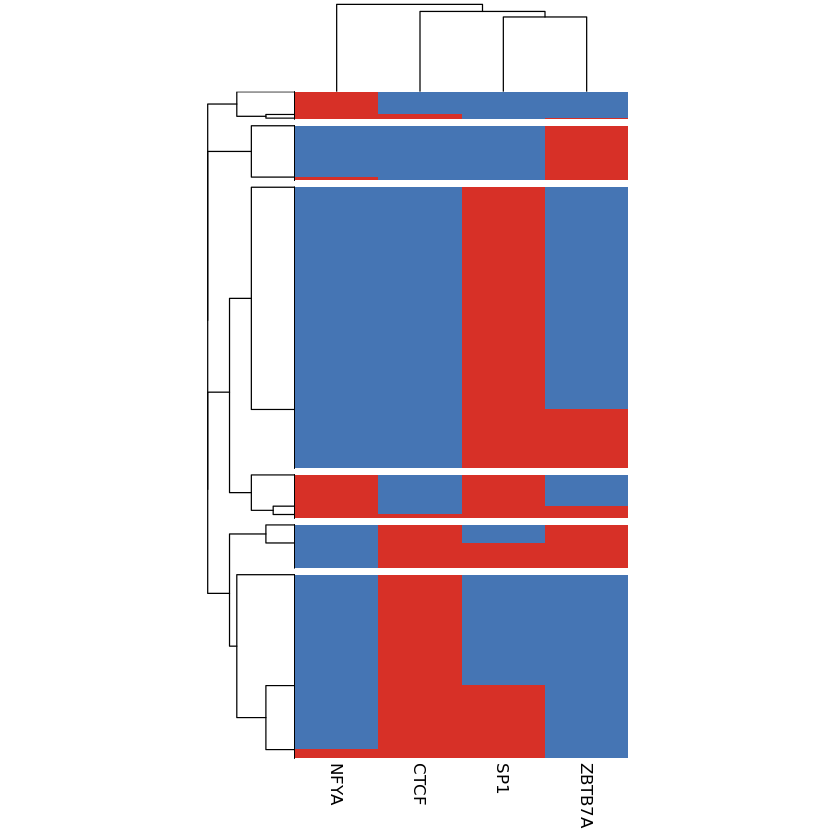

In [12]:
#Heatmap
heatmap <- pheatmap(silent_matrix_subset, show_rownames = FALSE, cluster_cols=TRUE, cluster_rows=TRUE, 
                    cellwidth = 50, cutree_rows = 6, display_numbers = FALSE, legend = FALSE, 
                    clustering_distance_rows = 'binary', clustering_distance_cols = 'binary')

In [25]:
pdf("/data/hodges_lab/ATAC-STARR_B-cells/results/NAR_paper_figures/multiomic_heatmap_silent.pdf", width=6, height=8)
heatmap
dev.off()

png 
  2

In [13]:
#Assign cluster number to each region. cbind cluster to the input matrix and then left_join with df to get genomic coordinates.  
silent_cluster <- cbind(silent_matrix_subset, Cluster = cutree(heatmap$tree_row,k = 6)) %>% rownames_to_column(var = "Peak_ID") %>% 
    left_join(silent, by = c("Peak_ID", "NFYA", "CTCF", "SP1", "ZBTB7A")) %>% 
    dplyr::select(chr, start, end, Peak_ID, Cluster, NFYA, CTCF, SP1, ZBTB7A)

#split into 6 clusters. 
SP1_clust <- filter(silent_cluster, Cluster == 1)
CTCF_SP1_clust <- filter(silent_cluster, Cluster == 2)
SP1_NFYA_clust <- filter(silent_cluster, Cluster == 3)
CTCF_SP1_ZBTB_clust <- filter(silent_cluster, Cluster == 4)
ZBTB_clust <- filter(silent_cluster, Cluster == 5)
NFYA_clust <- filter(silent_cluster, Cluster == 6)

In [14]:
#make gRanges object and annotate peaks to assign nearest neighbor. 
SP1_anno <- annotatePeak(with(SP1_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                            TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

CTCF_SP1_anno <- annotatePeak(with(CTCF_SP1_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                            TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

SP1_NFYA_anno <- annotatePeak(with(SP1_NFYA_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                            TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

CTCF_SP1_ZBTB_anno <- annotatePeak(with(CTCF_SP1_ZBTB_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                            TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

ZBTB_anno <- annotatePeak(with(ZBTB_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                            TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

NFYA_anno <- annotatePeak(with(NFYA_clust, GRanges(chr, IRanges(start, end))), tssRegion = c(-2000, 1000), 
                            TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb = "org.Hs.eg.db")

>> preparing features information...		 2022-02-04 12:57:39 PM 
>> identifying nearest features...		 2022-02-04 12:57:40 PM 
>> calculating distance from peak to TSS...	 2022-02-04 12:57:40 PM 
>> assigning genomic annotation...		 2022-02-04 12:57:40 PM 
>> adding gene annotation...			 2022-02-04 12:57:45 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-02-04 12:57:45 PM 
>> done...					 2022-02-04 12:57:45 PM 
>> preparing features information...		 2022-02-04 12:57:45 PM 
>> identifying nearest features...		 2022-02-04 12:57:45 PM 
>> calculating distance from peak to TSS...	 2022-02-04 12:57:46 PM 
>> assigning genomic annotation...		 2022-02-04 12:57:46 PM 
>> adding gene annotation...			 2022-02-04 12:57:51 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-02-04 12:57:51 PM 
>> done...					 2022-02-04 12:57:51 PM 
>> preparing features information...		 2022-02-04 12:57:51 PM 
>> identifying nearest features...		 2022-02-04 12:57:51 PM 
>> calculating distance from peak to TSS...	 2022-02-04 12:57:51 PM 
>> assigning genomic annotation...		 2022-02-04 12:57:51 PM 
>> adding gene annotation...			 2022-02-04 12:57:56 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-02-04 12:57:56 PM 
>> done...					 2022-02-04 12:57:56 PM 
>> preparing features information...		 2022-02-04 12:57:56 PM 
>> identifying nearest features...		 2022-02-04 12:57:56 PM 
>> calculating distance from peak to TSS...	 2022-02-04 12:57:57 PM 
>> assigning genomic annotation...		 2022-02-04 12:57:57 PM 
>> adding gene annotation...			 2022-02-04 12:58:02 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-02-04 12:58:02 PM 
>> done...					 2022-02-04 12:58:02 PM 
>> preparing features information...		 2022-02-04 12:58:02 PM 
>> identifying nearest features...		 2022-02-04 12:58:02 PM 
>> calculating distance from peak to TSS...	 2022-02-04 12:58:02 PM 
>> assigning genomic annotation...		 2022-02-04 12:58:02 PM 
>> adding gene annotation...			 2022-02-04 12:58:07 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-02-04 12:58:07 PM 
>> done...					 2022-02-04 12:58:07 PM 
>> preparing features information...		 2022-02-04 12:58:07 PM 
>> identifying nearest features...		 2022-02-04 12:58:07 PM 
>> calculating distance from peak to TSS...	 2022-02-04 12:58:08 PM 
>> assigning genomic annotation...		 2022-02-04 12:58:08 PM 
>> adding gene annotation...			 2022-02-04 12:58:13 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-02-04 12:58:13 PM 
>> done...					 2022-02-04 12:58:13 PM 


In [15]:
#perform reactome pathway enrichment analysis of nearest neighbor gene sets. Make list of genes first. 
#Then run on all simultaneously with clusterProfiler

silent_gene_list <- list(ZBTB7A = as.data.frame(ZBTB_anno)$geneId,  
                         `SP1&NFYA` = as.data.frame(SP1_NFYA_anno)$geneId, 
                         `CTCF&SP1&ZBTB` = as.data.frame(CTCF_SP1_ZBTB_anno)$geneId,
                         `CTCF&SP1` = as.data.frame(CTCF_SP1_anno)$geneId,
                         SP1 = as.data.frame(SP1_anno)$geneId,
                         NFYA = as.data.frame(NFYA_anno)$geneId)

silent_reactome_results <- compareCluster(silent_gene_list, fun = "enrichPathway", pvalueCutoff = 0.1)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



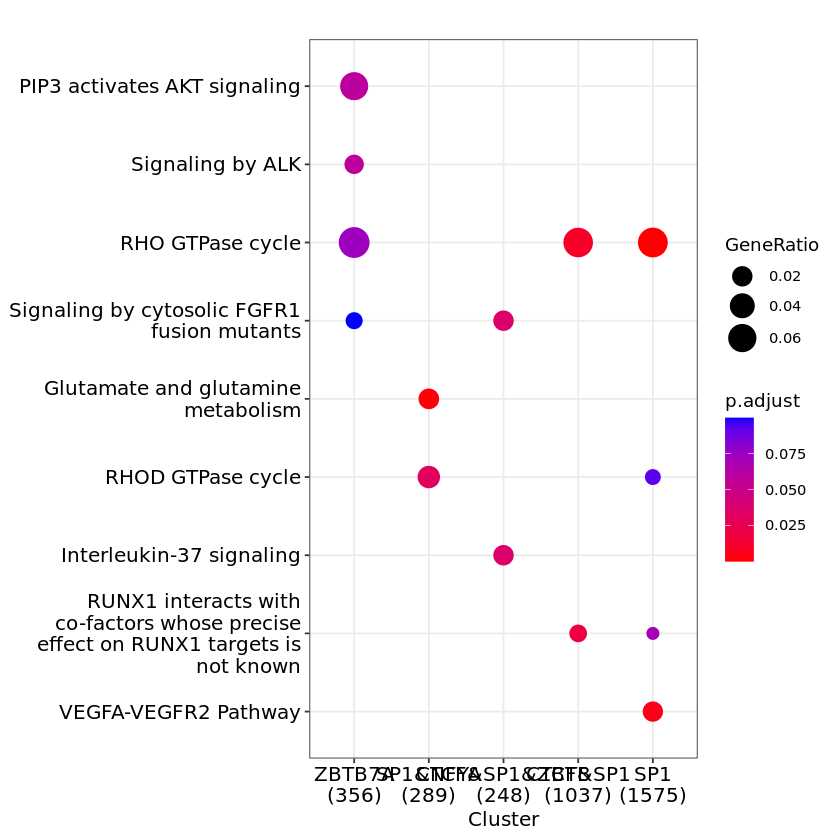

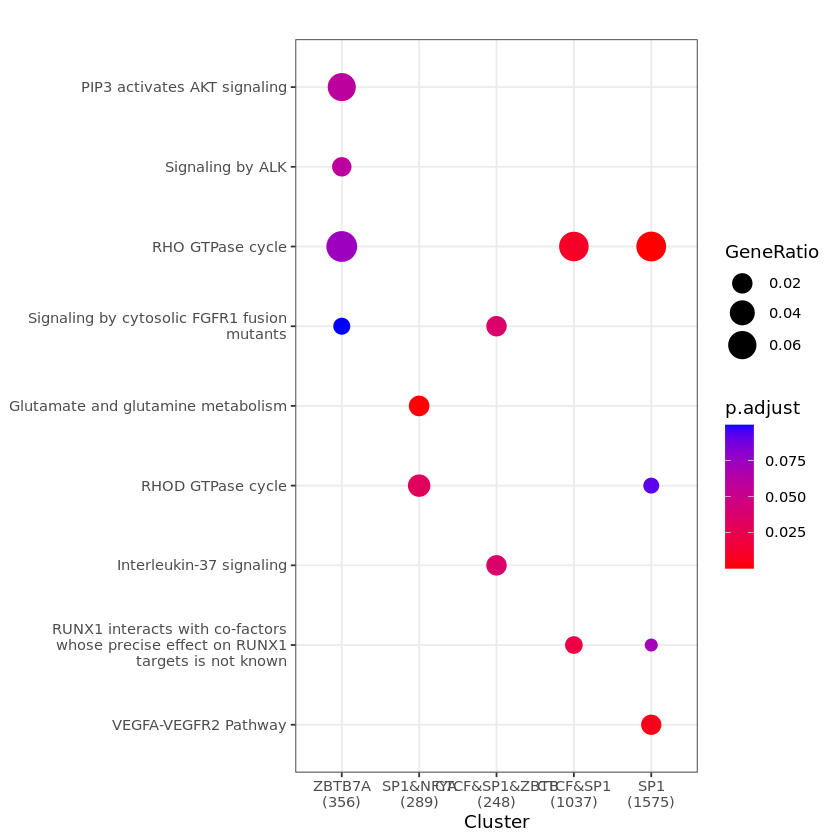

In [16]:
p <- dotplot(silent_reactome_results, showCategory = 2)  + theme_bw() + scale_y_discrete(labels = function(x) str_wrap(x, width = 35))
p

In [17]:
ggsave(p, filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/NAR_paper_figures/reactome_silent.pdf", 
       device = cairo_pdf, width = 6, height = 4)

## Genome browser 

In [1]:
library(Sushi)
library(tidyverse)
set.seed(123)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: biomaRt

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
✖ dplyr::select()  masks biomaRt::select()



In [2]:
#cannot use tidyverse, only base R
#signal
AS_ATAC <- read.delim("/data/hodges_lab/ATAC-STARR_B-cells/results/buenrostro-AS_accessibility-correlation/GM12878inGM12878_DNA_3-reps_no-dup_cpm.bedGraph", header = FALSE)

#footprints
SP1_footprints <- read.delim("/data/hodges_lab/ATAC-STARR_B-cells/results/ATAC-STARR_TF-footprinting/BINDetect/GM12878inGM12878_0.05/SP1_MA0079.4/beds/SP1_MA0079.4_GM12878inGM12878_DNA_bound.bed", header = FALSE)

KLF3_footprints <- read.delim("/data/hodges_lab/ATAC-STARR_B-cells/results/ATAC-STARR_TF-footprinting/BINDetect/GM12878inGM12878_0.05/KLF3_MA1516.1/beds/KLF3_MA1516.1_GM12878inGM12878_DNA_bound.bed", header = FALSE)

NFKB_footprints <- read.delim("/data/hodges_lab/ATAC-STARR_B-cells/results/ATAC-STARR_TF-footprinting/BINDetect/GM12878inGM12878_0.05/NFKB1_MA0105.4/beds/NFKB1_MA0105.4_GM12878inGM12878_DNA_bound.bed", header = FALSE)

IRF8_footprints <- read.delim("/data/hodges_lab/ATAC-STARR_B-cells/results/ATAC-STARR_TF-footprinting/BINDetect/GM12878inGM12878_0.05/IRF8_MA0652.1/beds/IRF8_MA0652.1_GM12878inGM12878_DNA_bound.bed", header = FALSE)


#peaks/regions
ATAC_peaks <- read.delim("/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/ChrAcc_peaks/GM12878inGM12878_DNA_genrich_3-replicates_0.0001-qvalue.narrowPeak", header = FALSE)
Activity_Peaks <- read.delim("/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink/active_regions.bed", header = FALSE)
Silent_Peaks <- read.delim("/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink/silent_regions.bed", header = FALSE)

#genes
RefSeq_genes <- read.delim("/data/hodges_lab/ATAC-STARR_B-cells/results/buenrostro-AS_accessibility-correlation/hg38.ncbiRefSeq_exons-Sushi-compatible.bed", header = FALSE)

In [3]:
RefSeq_genes_pos <- RefSeq_genes[RefSeq_genes[6] == "+",]
RefSeq_genes_pos[6] <- 1
RefSeq_genes_neg <- RefSeq_genes[RefSeq_genes[6] == "-",]
RefSeq_genes_neg[6] <- -1

genes <- rbind(RefSeq_genes_pos, RefSeq_genes_neg)
genes <- genes[genes[1] == "chr19",]

In [4]:
IRF8_footprints <- IRF8_footprints[IRF8_footprints[1]=="chr19",]
NFKB_footprints <- NFKB_footprints[NFKB_footprints[1]=="chr19",]
SP1_footprints <- SP1_footprints[SP1_footprints[1]=="chr19",]
KLF3_footprints <- KLF3_footprints[KLF3_footprints[1]=="chr19",]
Activity_Peaks <- Activity_Peaks[Activity_Peaks[1]=="chr19",]
Silent_Peaks <- Silent_Peaks[Silent_Peaks[1]=="chr19",]
AS_ATAC <- AS_ATAC[AS_ATAC [1]=="chr19",]

In [5]:
dev.off()
chrom = "chr19"
chromstart = 35611232
chromend = 35798446 

pdf("/data/hodges_lab/ATAC-STARR_B-cells/results/NAR_paper_figures/genome_browser_cpm.pdf", width=10, height=6)

layout(matrix(c(1,1,
                1,1,
                2,2,
                3,3,
                4,4,
                4,4,
                5,11,
                5,11,
                6,12,
                7,13,
                8,14,
                9,15,
                10,16,
                10,16), ncol = 2, byrow = TRUE))
par(mar=c(2,4,1,1)) #bottom,left,top,right

#1
plotGenes(geneinfo = genes,chrom,chromstart,chromend, bentline = FALSE, arrowlength = 0.005, col = "black",types = "exon", maxrows=2, bheight=0.3, 
          labeloffset=0.5, fontsize=0.75, labeltext=TRUE)

#2
plotBed(beddata = Silent_Peaks, chrom,chromstart,chromend, color = "red2", row = 'supplied')
zoombox(passthrough=TRUE)

#3
plotBed(beddata = Activity_Peaks, chrom,chromstart,chromend, color = "blue2", row = 'supplied')
zoombox(passthrough=TRUE)

#4
plotBedgraph(AS_ATAC, chrom,chromstart,chromend,color = "black")
axis(side=2,las=2,tcl=.2)
labelgenome(chrom,chromstart,chromend,side=1,n=3,scale="Kb")

zoomregion1 = c(35700602,35715554)
zoomregion2 = c(35640787,35646000)
zoomsregion(zoomregion1,extend=c(0.01,0.13),wideextend=0.05, offsets=c(0.535,0))
zoomsregion(zoomregion2,extend=c(0.01,0.13),wideextend=0.05, offsets=c(0,0.535))

## zoom region 2

#5
plotGenes(geneinfo = genes,chrom,chromstart=zoomregion2[1],chromend=zoomregion2[2], bentline = FALSE, arrowlength = 0.005, col = "black",types = "exon", maxrows=2, bheight=0.15, 
          labeloffset=0.5, fontsize=0.75, labeltext=TRUE)
#6
plotBed(beddata = SP1_footprints, chrom,chromstart=zoomregion2[1],chromend=zoomregion2[2], color = "purple", row = 'supplied')
zoombox(passthrough=TRUE)

#7
plotBed(beddata = KLF3_footprints, chrom,chromstart=zoomregion2[1],chromend=zoomregion2[2], color = "purple", row = 'supplied')
zoombox(passthrough=TRUE)

#8
plotBed(beddata = Silent_Peaks, chrom,chromstart=zoomregion2[1],chromend=zoomregion2[2], color = "red2", row = 'supplied')
zoombox(passthrough=TRUE)

#9
plotBed(beddata = Activity_Peaks, chrom,chromstart=zoomregion2[1],chromend=zoomregion2[2], color = "blue2", row = 'supplied')
zoombox(passthrough=TRUE)

#10
plotBedgraph(AS_ATAC, chrom,chromstart=zoomregion2[1],chromend=zoomregion2[2],color = "black")
axis(side=2,las=2,tcl=.2)
labelgenome(chrom,chromstart=zoomregion2[1],chromend=zoomregion2[2],n=2,scale="Kb",edgeblankfraction=0.2,cex.axis=.75)
zoombox(passthrough=FALSE)

## zoom region 1
#11
plotGenes(geneinfo = genes,chrom,chromstart=zoomregion1[1],chromend=zoomregion1[2], bentline = FALSE, arrowlength = 0.005, col = "black",types = "exon", maxrows=2, bheight=0.15, 
          labeloffset=0.5, fontsize=0.75, labeltext=TRUE)

#12
plotBed(beddata = IRF8_footprints, chrom,chromstart=zoomregion1[1],chromend=zoomregion1[2], color = "orange", row = 'supplied')
zoombox(passthrough=TRUE)

#13
plotBed(beddata = NFKB_footprints, chrom,chromstart=zoomregion1[1],chromend=zoomregion1[2], color = "orange", row = 'supplied')
zoombox(passthrough=TRUE)

#14
plotBed(beddata = Silent_Peaks, chrom,chromstart=zoomregion1[1],chromend=zoomregion1[2], color = "red2", row = 'supplied')
zoombox(passthrough=TRUE)

#15
plotBed(beddata = Activity_Peaks, chrom,chromstart=zoomregion1[1],chromend=zoomregion1[2], color = "blue2", row = 'supplied')
zoombox(passthrough=TRUE)

#16
plotBedgraph(AS_ATAC, chrom,chromstart=zoomregion1[1],chromend=zoomregion1[2],color = "black")
axis(side=2,las=2,tcl=.2)
labelgenome(chrom,chromstart=zoomregion1[1],chromend=zoomregion1[2],n=2,scale="Kb",edgeblankfraction=0.2,cex.axis=.75)
zoombox(passthrough=FALSE)


dev.off()

null device 
          1

[[1]]
NULL

[[2]]
function (n) 
{
    x <- ramp(seq.int(0, 1, length.out = n))
    if (ncol(x) == 4L) 
        rgb(x[, 1L], x[, 2L], x[, 3L], x[, 4L], maxColorValue = 255)
    else rgb(x[, 1L], x[, 2L], x[, 3L], maxColorValue = 255)
}
<bytecode: 0x56202cd4b010>
<environment: 0x56202cd4dcc0>

[1] "yes"
[1] "yes"


[[1]]
NULL

[[2]]
function (n) 
{
    x <- ramp(seq.int(0, 1, length.out = n))
    if (ncol(x) == 4L) 
        rgb(x[, 1L], x[, 2L], x[, 3L], x[, 4L], maxColorValue = 255)
    else rgb(x[, 1L], x[, 2L], x[, 3L], maxColorValue = 255)
}
<bytecode: 0x56202cd4b010>
<environment: 0x561fe18eb6c8>

[1] "yes"
[1] "yes"
[1] "yes"
[1] "yes"


[[1]]
NULL

[[2]]
function (n) 
{
    x <- ramp(seq.int(0, 1, length.out = n))
    if (ncol(x) == 4L) 
        rgb(x[, 1L], x[, 2L], x[, 3L], x[, 4L], maxColorValue = 255)
    else rgb(x[, 1L], x[, 2L], x[, 3L], maxColorValue = 255)
}
<bytecode: 0x56202cd4b010>
<environment: 0x5620022a22d0>

[1] "yes"
[1] "yes"
[1] "yes"
[1] "yes"


null device 
          1